In [ ]:
#=======================================================================
# KLASIFIKASI DATA LOGISTIC REGRESSION
#=======================================================================

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 11.5 MB/s eta 0:00:00


In [4]:
# Text preprocessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
from nltk.tokenize import word_tokenize

In [6]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 63.5 MB/s eta 0:00:00


In [7]:
# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
import gensim.downloader as api

In [8]:
# Machine Learning - LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [9]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

In [10]:
# Download NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
import pandas as pd

print("\n[1] Loading Data...")

df_positif = pd.read_csv(
    'komentar_positif.csv',
    engine='python',
    sep=None,
    header=None,
    names=['komentar'],
    on_bad_lines='skip'
)

df_negatif = pd.read_csv(
    'komentar_negatif.csv',
    engine='python',
    sep=None,
    header=None,
    names=['komentar'],
    on_bad_lines='skip'
)

df_netral = pd.read_csv(
    'komentar_netral.csv',
    engine='python',
    sep=None,
    header=None,
    names=['komentar'],
    on_bad_lines='skip'
)

df_positif['label'] = 'positif'
df_negatif['label'] = 'negatif'
df_netral['label']  = 'netral'

df = pd.concat([df_positif, df_negatif, df_netral], ignore_index=True)

print("Total data:", len(df))
print(df['label'].value_counts())


[1] Loading Data...
Total data: 206
label
negatif    79
positif    75
netral     52
Name: count, dtype: int64


In [20]:
import pandas as pd
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk

nltk.download('punkt')

# Inisialisasi Sastrawi
factory_stemmer = StemmerFactory()
stemmer = factory_stemmer.create_stemmer()
factory_stopword = StopWordRemoverFactory()
stopword_remover = factory_stopword.create_stop_word_remover()

#-------------------------------
# LOAD DATA CSV SEBAGAI PLAIN TEXT
#-------------------------------
def load_csv_as_text(file_path, label):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.read().splitlines()
    df = pd.DataFrame(lines, columns=['komentar'])
    df['label'] = label
    return df

df_positif = load_csv_as_text('komentar_positif.csv', 'positif')
df_negatif  = load_csv_as_text('komentar_negatif.csv', 'negatif')
df_netral   = load_csv_as_text('komentar_netral.csv', 'netral')

# Gabungkan semua data
df = pd.concat([df_positif, df_negatif, df_netral], ignore_index=True)

#-------------------------------
# PREPROCESSING
#-------------------------------
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)  # Ganti punctuation dengan spasi
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    text = clean_text(text)
    text = stopword_remover.remove(text)
    text = stemmer.stem(text)
    return text

df['komentar_clean'] = df['komentar'].apply(clean_text)
df['komentar_processed'] = df['komentar'].apply(preprocess_text)

#-------------------------------
# VALIDASI
#-------------------------------
print("✓ Preprocessing selesai!\n")
print("Contoh preprocessing:")
for i in range(min(5, len(df))):
    print(f"Original   : {df['komentar'].iloc[i]}")
    print(f"Cleaned    : {df['komentar_clean'].iloc[i]}")
    print(f"Processed  : {df['komentar_processed'].iloc[i]}")
    print("-"*50)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✓ Preprocessing selesai!

Contoh preprocessing:
Original   : comment
Cleaned    : comment
Processed  : comment
--------------------------------------------------
Original   : Lanjutkan pak Purbaya kami rakyat Indonesia di Kalimantan mendukung dan selalu memantau bapak tim dan keluarga atas keselamatan bapak bapak semua.kalau bapak terancam kami ada di sekitar bapak dan keluarga.
Cleaned    : lanjutkan pak purbaya kami rakyat indonesia di kalimantan mendukung dan selalu memantau bapak tim dan keluarga atas keselamatan bapak bapak semua kalau bapak terancam kami ada di sekitar bapak dan keluarga
Processed  : lanjut pak purbaya rakyat indonesia kalimantan dukung selalu pantau bapak tim keluarga atas selamat bapak bapak semua kalau bapak ancam ada sekitar bapak keluarga
--------------------------------------------------
Original   : BANGUN KILANG BARU: Menguntungkan bagi Indonesia tapi merugikan bagi para mafia minyak Indonesia 
Cleaned    : bangun kilang baru menguntungkan bagi indonesia 

In [22]:
#=======================================================================
# BAGIAN 3: SPLIT DATA
#=======================================================================

from sklearn.model_selection import train_test_split

print("\n[3] Splitting Data (80% Train, 20% Test)...")

# Gunakan kolom yang benar
X = df['komentar_processed']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"  Training data: {len(X_train)}")
print(f"  Testing data: {len(X_test)}")


[3] Splitting Data (80% Train, 20% Test)...
  Training data: 247
  Testing data: 62


In [23]:
#=======================================================================
# BAGIAN 4: FEATURE EXTRACTION & CLASSIFICATION
#=======================================================================

results = []

print("\n" + "="*80)
print("FEATURE EXTRACTION & CLASSIFICATION - LOGISTIC REGRESSION")
print("="*80)


FEATURE EXTRACTION & CLASSIFICATION - LOGISTIC REGRESSION


In [24]:
#---------------------------------------------------------------------------
# 4.1 TF-IDF + Logistic Regression
#---------------------------------------------------------------------------

print("\n[4.1] TF-IDF + Logistic Regression")
print("-" * 50)

tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Logistic Regression dengan parameter optimal
model_tfidf = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
    multi_class='multinomial'
)
model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
prec_tfidf = precision_score(y_test, y_pred_tfidf, average='weighted')
rec_tfidf = recall_score(y_test, y_pred_tfidf, average='weighted')
f1_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')

print(f"  Accuracy : {acc_tfidf:.4f}")
print(f"  Precision: {prec_tfidf:.4f}")
print(f"  Recall   : {rec_tfidf:.4f}")
print(f"  F1-Score : {f1_tfidf:.4f}")

results.append({
    'Method': 'TF-IDF',
    'Accuracy': acc_tfidf,
    'Precision': prec_tfidf,
    'Recall': rec_tfidf,
    'F1-Score': f1_tfidf
})

print("\n  Classification Report:")
print(classification_report(y_test, y_pred_tfidf))


[4.1] TF-IDF + Logistic Regression
--------------------------------------------------
  Accuracy : 0.6290
  Precision: 0.6544
  Recall   : 0.6290
  F1-Score : 0.6335

  Classification Report:
              precision    recall  f1-score   support

     negatif       0.65      0.55      0.59        20
      netral       0.52      0.68      0.59        22
     positif       0.81      0.65      0.72        20

    accuracy                           0.63        62
   macro avg       0.66      0.63      0.64        62
weighted avg       0.65      0.63      0.63        62



In [25]:
#---------------------------------------------------------------------------
# 4.2 BAG OF WORDS (BOW) + Logistic Regression
#---------------------------------------------------------------------------

print("\n[4.2] Bag of Words (BOW) + Logistic Regression")
print("-" * 50)

bow_vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

model_bow = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
    multi_class='multinomial'
)
model_bow.fit(X_train_bow, y_train)

y_pred_bow = model_bow.predict(X_test_bow)

acc_bow = accuracy_score(y_test, y_pred_bow)
prec_bow = precision_score(y_test, y_pred_bow, average='weighted')
rec_bow = recall_score(y_test, y_pred_bow, average='weighted')
f1_bow = f1_score(y_test, y_pred_bow, average='weighted')

print(f"  Accuracy : {acc_bow:.4f}")
print(f"  Precision: {prec_bow:.4f}")
print(f"  Recall   : {rec_bow:.4f}")
print(f"  F1-Score : {f1_bow:.4f}")

results.append({
    'Method': 'Bag of Words',
    'Accuracy': acc_bow,
    'Precision': prec_bow,
    'Recall': rec_bow,
    'F1-Score': f1_bow
})

print("\n  Classification Report:")
print(classification_report(y_test, y_pred_bow))


[4.2] Bag of Words (BOW) + Logistic Regression
--------------------------------------------------
  Accuracy : 0.6290
  Precision: 0.6342
  Recall   : 0.6290
  F1-Score : 0.6288

  Classification Report:
              precision    recall  f1-score   support

     negatif       0.58      0.70      0.64        20
      netral       0.55      0.50      0.52        22
     positif       0.78      0.70      0.74        20

    accuracy                           0.63        62
   macro avg       0.64      0.63      0.63        62
weighted avg       0.63      0.63      0.63        62



In [26]:
#---------------------------------------------------------------------------
# 4.3 WORD2VEC + Logistic Regression
#---------------------------------------------------------------------------

print("\n[4.3] Word2Vec + Logistic Regression")
print("-" * 50)

# Tokenize untuk Word2Vec
X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]

# Train Word2Vec model
print("  Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=X_train_tokens,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=10
)

def document_vector(doc, model):
    """Convert document to average word vector"""
    doc = [word for word in doc if word in model.wv]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

# Convert to vectors
X_train_w2v = np.array([document_vector(doc, w2v_model) for doc in X_train_tokens])
X_test_w2v = np.array([document_vector(doc, w2v_model) for doc in X_test_tokens])

# Logistic Regression untuk continuous features
model_w2v = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
    multi_class='multinomial'
)
model_w2v.fit(X_train_w2v, y_train)

y_pred_w2v = model_w2v.predict(X_test_w2v)

acc_w2v = accuracy_score(y_test, y_pred_w2v)
prec_w2v = precision_score(y_test, y_pred_w2v, average='weighted')
rec_w2v = recall_score(y_test, y_pred_w2v, average='weighted')
f1_w2v = f1_score(y_test, y_pred_w2v, average='weighted')

print(f"  Accuracy : {acc_w2v:.4f}")
print(f"  Precision: {prec_w2v:.4f}")
print(f"  Recall   : {rec_w2v:.4f}")
print(f"  F1-Score : {f1_w2v:.4f}")

results.append({
    'Method': 'Word2Vec',
    'Accuracy': acc_w2v,
    'Precision': prec_w2v,
    'Recall': rec_w2v,
    'F1-Score': f1_w2v
})

print("\n  Classification Report:")
print(classification_report(y_test, y_pred_w2v))


[4.3] Word2Vec + Logistic Regression
--------------------------------------------------
  Training Word2Vec model...
  Accuracy : 0.3548
  Precision: 0.1259
  Recall   : 0.3548
  F1-Score : 0.1859

  Classification Report:
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00        20
      netral       0.35      1.00      0.52        22
     positif       0.00      0.00      0.00        20

    accuracy                           0.35        62
   macro avg       0.12      0.33      0.17        62
weighted avg       0.13      0.35      0.19        62



In [27]:
#---------------------------------------------------------------------------
# 4.4 GLOVE (Pre-trained) + Logistic Regression
#---------------------------------------------------------------------------

print("\n[4.4] GloVe (Pre-trained) + Logistic Regression")
print("-" * 50)
print("  Loading pre-trained GloVe model (glove-wiki-gigaword-100)...")
print("  (This may take a while on first run...)")

try:
    # Load pre-trained GloVe
    glove_model = api.load("glove-wiki-gigaword-100")

    def document_vector_glove(doc, model):
        """Convert document to average GloVe vector"""
        vectors = []
        for word in doc:
            try:
                vectors.append(model[word])
            except KeyError:
                continue
        if len(vectors) == 0:
            return np.zeros(100)
        return np.mean(vectors, axis=0)

    # Convert to vectors
    X_train_glove = np.array([document_vector_glove(doc, glove_model) for doc in X_train_tokens])
    X_test_glove = np.array([document_vector_glove(doc, glove_model) for doc in X_test_tokens])

    # Logistic Regression
    model_glove = LogisticRegression(
        max_iter=1000,
        random_state=42,
        solver='lbfgs',
        multi_class='multinomial'
    )
    model_glove.fit(X_train_glove, y_train)

    y_pred_glove = model_glove.predict(X_test_glove)

    acc_glove = accuracy_score(y_test, y_pred_glove)
    prec_glove = precision_score(y_test, y_pred_glove, average='weighted')
    rec_glove = recall_score(y_test, y_pred_glove, average='weighted')
    f1_glove = f1_score(y_test, y_pred_glove, average='weighted')

    print(f"  Accuracy : {acc_glove:.4f}")
    print(f"  Precision: {prec_glove:.4f}")
    print(f"  Recall   : {rec_glove:.4f}")
    print(f"  F1-Score : {f1_glove:.4f}")

    results.append({
        'Method': 'GloVe',
        'Accuracy': acc_glove,
        'Precision': prec_glove,
        'Recall': rec_glove,
        'F1-Score': f1_glove
    })

    print("\n  Classification Report:")
    print(classification_report(y_test, y_pred_glove))

except Exception as e:
    print(f"  ⚠ Error loading GloVe: {e}")
    print("  Skipping GloVe evaluation...")


[4.4] GloVe (Pre-trained) + Logistic Regression
--------------------------------------------------
  Loading pre-trained GloVe model (glove-wiki-gigaword-100)...
  (This may take a while on first run...)
[==================================================] 100.0% 128.1/128.1MB downloaded
  Accuracy : 0.5323
  Precision: 0.5308
  Recall   : 0.5323
  F1-Score : 0.5313

  Classification Report:
              precision    recall  f1-score   support

     negatif       0.53      0.50      0.51        20
      netral       0.45      0.45      0.45        22
     positif       0.62      0.65      0.63        20

    accuracy                           0.53        62
   macro avg       0.53      0.53      0.53        62
weighted avg       0.53      0.53      0.53        62



In [28]:
#=======================================================================
# BAGIAN 5: COMPARISON & VISUALIZATION
#=======================================================================

print("\n" + "="*80)
print("COMPARISON OF ALL METHODS")
print("="*80)

df_results = pd.DataFrame(results)
print("\n", df_results.to_string(index=False))

# Save results to CSV
df_results.to_csv('classification_results_logistic.csv', index=False)
print("\n✓ Results saved to: classification_results_logistic.csv")

# Find best method
best_method = df_results.loc[df_results['Accuracy'].idxmax()]
print(f"\n🏆 Best Method: {best_method['Method']}")
print(f"   Accuracy: {best_method['Accuracy']:.4f}")
print(f"   F1-Score: {best_method['F1-Score']:.4f}")


COMPARISON OF ALL METHODS

       Method  Accuracy  Precision   Recall  F1-Score
      TF-IDF  0.629032   0.654363 0.629032  0.633508
Bag of Words  0.629032   0.634229 0.629032  0.628837
    Word2Vec  0.354839   0.125911 0.354839  0.185868
       GloVe  0.532258   0.530762 0.532258  0.531280

✓ Results saved to: classification_results_logistic.csv

🏆 Best Method: TF-IDF
   Accuracy: 0.6290
   F1-Score: 0.6335



[6] Creating Visualizations...
  ✓ Saved: comparison_metrics_logistic.png


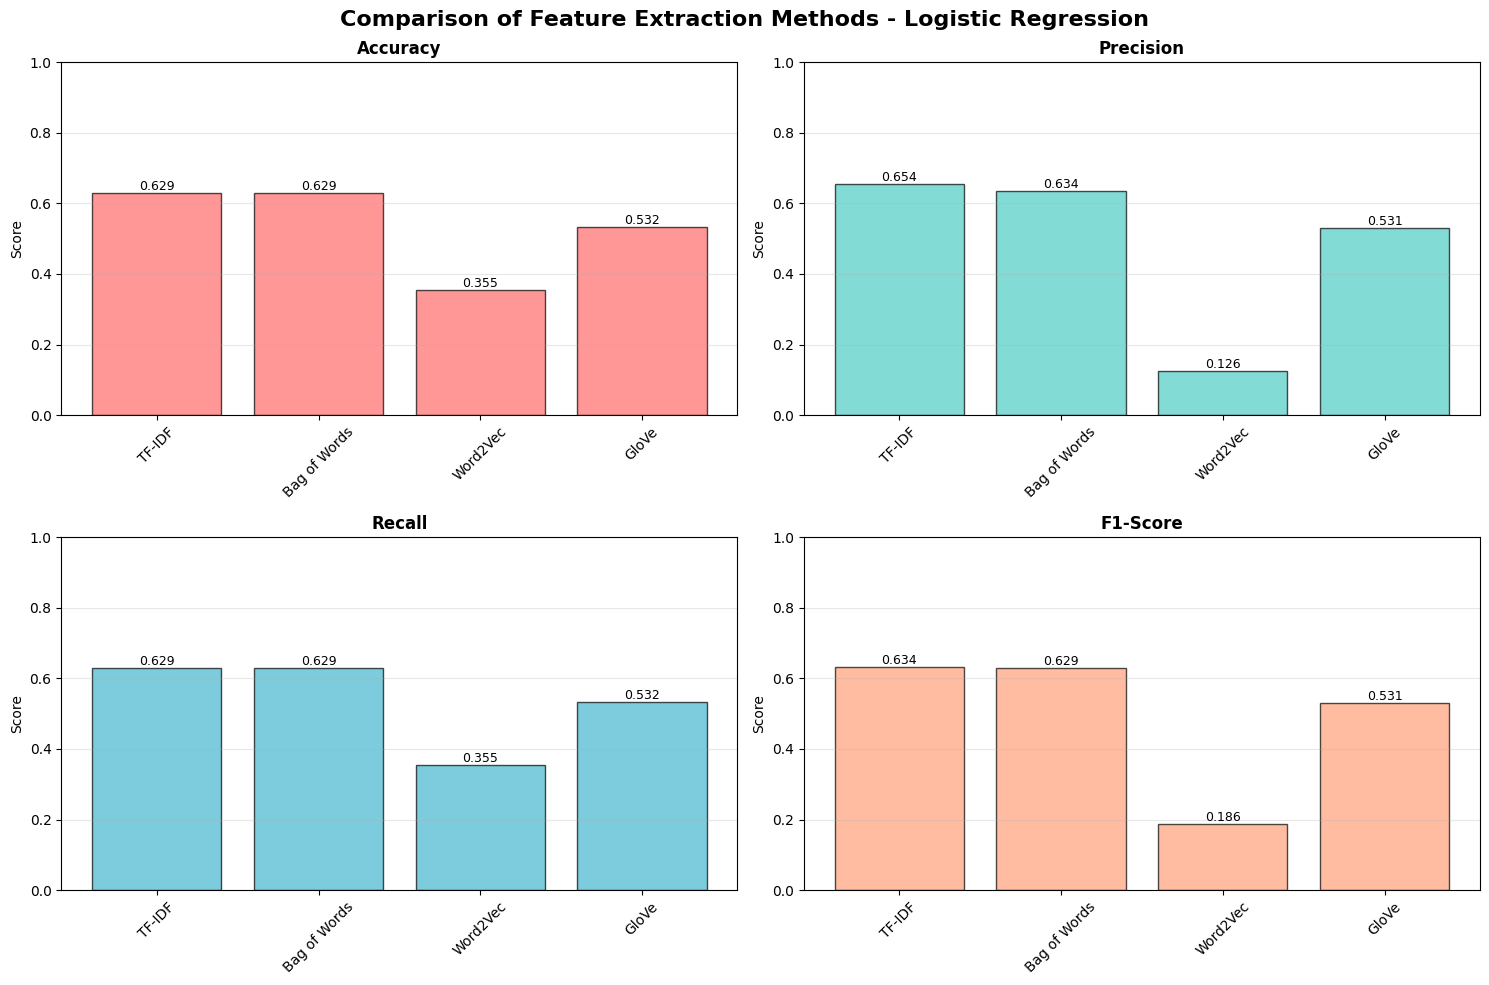

In [29]:
#=======================================================================
# BAGIAN 6: VISUALIZATION
#=======================================================================

print("\n[6] Creating Visualizations...")

# 6.1 Comparison bar chart
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparison of Feature Extraction Methods - Logistic Regression',
             fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (ax, metric, color) in enumerate(zip(axes.flat, metrics, colors)):
    bars = ax.bar(df_results['Method'], df_results[metric],
                  color=color, alpha=0.7, edgecolor='black')
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('comparison_metrics_logistic.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: comparison_metrics_logistic.png")

  ✓ Saved: confusion_matrix_logistic.png


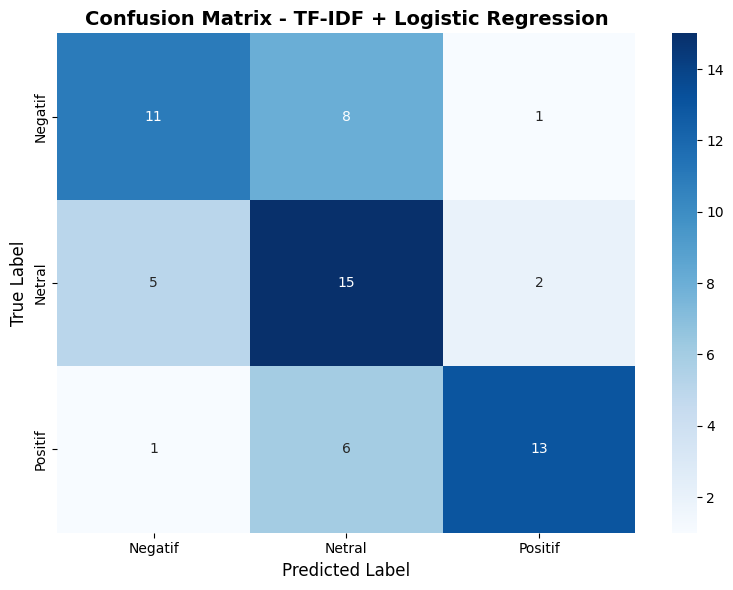

In [30]:
# 6.2 Confusion Matrix for best method (TF-IDF)
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'],
            ax=ax)
ax.set_title('Confusion Matrix - TF-IDF + Logistic Regression',
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix_logistic.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: confusion_matrix_logistic.png")

  ✓ Saved: radar_comparison_logistic.png


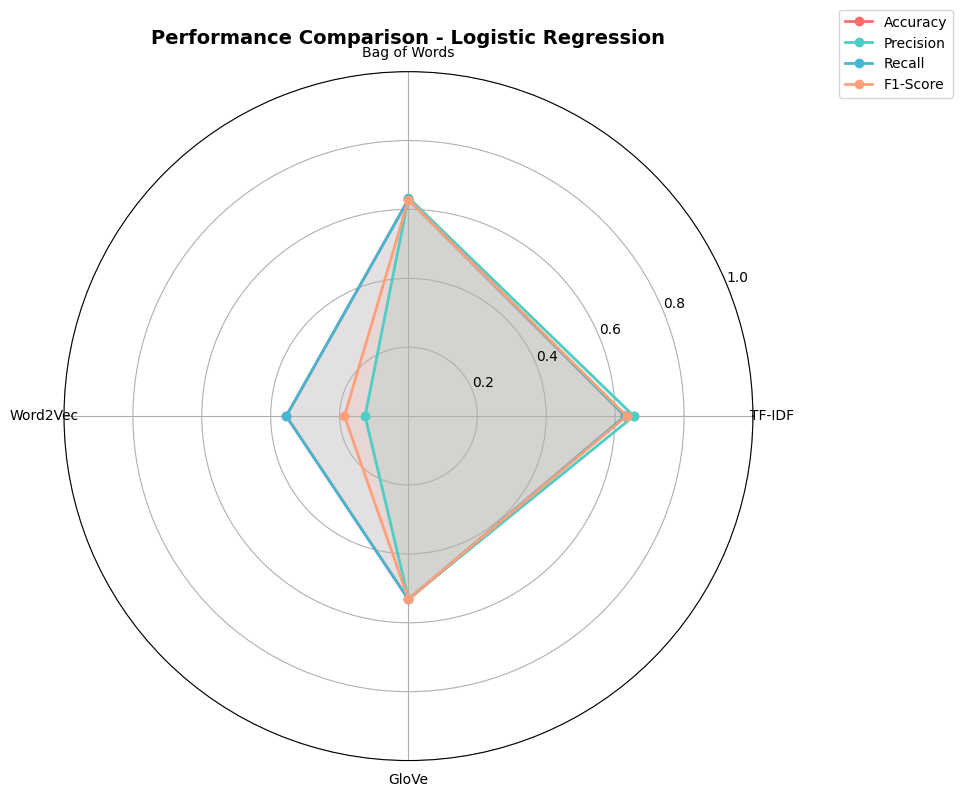

In [31]:
# 6.3 Overall comparison radar chart
categories = list(df_results['Method'])
N = len(categories)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for metric, color in zip(metrics_to_plot, colors_radar):
    values = df_results[metric].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=metric, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_ylim(0, 1)
ax.set_title('Performance Comparison - Logistic Regression',
             size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.savefig('radar_comparison_logistic.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: radar_comparison_logistic.png")

In [33]:
#=======================================================================
# BAGIAN 7: SAVE PREDICTIONS
#=======================================================================

print("\n[7] Saving Predictions...")

# Create dataframe with predictions from all methods
df_predictions = pd.DataFrame({
    'comment_original': df.loc[X_test.index, 'komentar'].values,       # ganti 'comment' → 'komentar'
    'comment_processed': X_test.values,
    'true_label': y_test.values,
    'pred_tfidf': y_pred_tfidf,
    'pred_bow': y_pred_bow,
    'pred_word2vec': y_pred_w2v
})

# Add GloVe predictions if available
if 'y_pred_glove' in locals():
    df_predictions['pred_glove'] = y_pred_glove

# Save to CSV
df_predictions.to_csv('predictions_comparison_logistic.csv', index=False)
print("  ✓ Saved: predictions_comparison_logistic.csv")


[7] Saving Predictions...
  ✓ Saved: predictions_comparison_logistic.csv


In [34]:
#=======================================================================
# FINAL SUMMARY
#=======================================================================

print("\n" + "="*80)
print("CLASSIFICATION COMPLETED!")
print("="*80)
print("\n🏆 Output Files:")
print("  1. classification_results_logistic.csv - Performance metrics untuk semua metode")
print("  2. predictions_comparison_logistic.csv - Prediksi dari semua metode")
print("  3. comparison_metrics_logistic.png - Bar chart perbandingan metrik")
print("  4. confusion_matrix_logistic.png - Confusion matrix TF-IDF")
print("  5. radar_comparison_logistic.png - Radar chart perbandingan performa")

print("\n🏆 Summary:")
print(f"  ✓ Total data: {len(df)}")
print(f"  ✓ Training: {len(X_train)} | Testing: {len(X_test)}")
print(f"  ✓ Feature extraction methods tested: {len(results)}")
print(f"  ✓ Best method: {best_method['Method']} (Accuracy: {best_method['Accuracy']:.4f})")
print(f"  ✓ Classifier: Logistic Regression")

print("\n" + "="*80)


CLASSIFICATION COMPLETED!

🏆 Output Files:
  1. classification_results_logistic.csv - Performance metrics untuk semua metode
  2. predictions_comparison_logistic.csv - Prediksi dari semua metode
  3. comparison_metrics_logistic.png - Bar chart perbandingan metrik
  4. confusion_matrix_logistic.png - Confusion matrix TF-IDF
  5. radar_comparison_logistic.png - Radar chart perbandingan performa

🏆 Summary:
  ✓ Total data: 309
  ✓ Training: 247 | Testing: 62
  ✓ Feature extraction methods tested: 4
  ✓ Best method: TF-IDF (Accuracy: 0.6290)
  ✓ Classifier: Logistic Regression

